# UDL Mini-Project

## Import libraries & set device

In [1]:
!sudo apt-get install texlive-latex-extra texlive-fonts-recommended dvipng cm-super

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  cm-super-minimal dvisvgm fonts-droid-fallback fonts-lato fonts-lmodern
  fonts-noto-mono fonts-texgyre fonts-urw-base35 ghostscript
  libapache-pom-java libcommons-logging-java libcommons-parent-java
  libfontbox-java libfontenc1 libgs9 libgs9-common libidn12 libijs-0.35
  libjbig2dec0 libkpathsea6 libpdfbox-java libptexenc1 libruby3.0 libsynctex2
  libteckit0 libtexlua53 libtexluajit2 libwoff1 libzzip-0-13 lmodern
  pfb2t1c2pfb poppler-data preview-latex-style rake ruby ruby-net-telnet
  ruby-rubygems ruby-webrick ruby-xmlrpc ruby3.0 rubygems-integration t1utils
  tex-common tex-gyre texlive-base texlive-binaries texlive-latex-base
  texlive-latex-recommended texlive-pictures texlive-plain-generic tipa
  xfonts-encodings xfonts-utils
Suggested packages:
  fonts-noto fonts-freefont-otf | fonts-freefont-ttf ghostscript-x
  libavalon-fram

In [2]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import random
import copy
import torch.nn.functional as F
import math
import json

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Load Permuted MNIST

In [4]:
# Set random seed for reproducibility
torch.manual_seed(42)
num_tasks = 8
perms = [torch.from_numpy(np.random.RandomState(12345 + t).permutation(28*28)).long()
         for t in range(num_tasks)]

# Generate permutation
rng_permute = np.random.RandomState(92916)
idx_permute = torch.from_numpy(rng_permute.permutation(28*28)).long()

def permute_image(image, permutation):
  x = image.view(-1)[permutation]
  return x.view(28, 28).unsqueeze(0)

def get_permute_transform(permutation):
    return transforms.Compose([
        transforms.ToTensor(),
        transforms.Lambda(lambda x: permute_image(x, permutation)),
        transforms.Normalize((0.1307,), (0.3081,)) # Normalize using mean and std of MNIST
    ])

task_data_loaders = []
task_test_loaders = []

for perm in perms:
    transform = get_permute_transform(perm)
    task_dataset = datasets.MNIST('./data', train=True, download=True, transform=transform)
    task_loader = DataLoader(task_dataset, batch_size=256, shuffle=True)
    task_data_loaders.append(task_loader)

    task_test_dataset = datasets.MNIST('./data', train=False, download=True, transform=transform)
    task_test_loader = DataLoader(task_test_dataset, batch_size=1000, shuffle=False)
    task_test_loaders.append(task_test_loader)

100%|██████████| 9.91M/9.91M [00:00<00:00, 37.3MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 1.15MB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 10.0MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 8.94MB/s]


## Define Models

### Simple NN

In [51]:
class VanillaNN(nn.Module):
    def __init__(self):
        super(VanillaNN, self).__init__()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(28*28, 100)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(100, 100)
        self.fc3 = nn.Linear(100, 10)

    def forward(self, x):
        x = self.flatten(x)
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x

### VCL

In [52]:
class VariationalLinear(nn.Module):
    def __init__(self, in_features, out_features, init_weight_mu=None,
                 init_bias_mu=None, init_weight_var=None, init_bias_var=None):
        super(VariationalLinear, self).__init__()
        self.in_features = in_features
        self.out_features = out_features

        # Create mean parameters if provided. Otherwise, allocate new tensors.
        if init_weight_mu is not None:
            self.weight_mu = nn.Parameter(init_weight_mu.clone())
        else:
            self.weight_mu = nn.Parameter(torch.Tensor(out_features, in_features))

        if init_bias_mu is not None:
            self.bias_mu = nn.Parameter(init_bias_mu.clone())
        else:
            self.bias_mu = nn.Parameter(torch.Tensor(out_features))

        if init_weight_var is not None:
            self.weight_logvar = nn.Parameter(init_weight_var.clone())
        else:
            self.weight_logvar = nn.Parameter(torch.Tensor(out_features, in_features))

        if init_bias_var is not None:
          self.bias_logvar = nn.Parameter(init_bias_var.clone())
        else:
          self.bias_logvar = nn.Parameter(torch.Tensor(out_features))

        self.reset_parameters(init_weight_mu, init_bias_mu, init_weight_var, init_bias_var)

    def reset_parameters(self, init_weight_mu=None, init_bias_mu=None,
                         init_weight_var=None, init_bias_var=None):
        # If initial means are not provided, use Kaiming initialization
        if init_weight_mu is None:
            nn.init.kaiming_uniform_(self.weight_mu)

        if init_weight_var is None:
            self.weight_logvar.data.fill_(math.log(1e-6))

        # If initial biases are not provided, use a similar approach
        # to that of the paper.
        if init_bias_mu is None:
            nn.init.trunc_normal_(self.bias_mu, std=0.1)

        if init_bias_var is None:
            self.bias_logvar.data.fill_(math.log(1e-6))

    def forward(self, input):
        if self.training:
            epsilon_w = torch.randn_like(self.weight_mu)
            weight = self.weight_mu + torch.exp(0.5 * self.weight_logvar) * epsilon_w
            epsilon_b = torch.randn_like(self.bias_mu)
            bias = self.bias_mu + torch.exp(0.5 * self.bias_logvar) * epsilon_b
        else:
            weight = self.weight_mu
            bias = self.bias_mu
        return F.linear(input, weight, bias)

class VariationalMNISTNet(nn.Module):
    def __init__(self, init_fc1_weight=None, init_fc1_bias=None,
                       init_fc2_weight=None, init_fc2_bias=None,
                       init_fc3_weight=None, init_fc3_bias=None,
                       init_fc1_weight_var=None, init_fc1_bias_var=None,
                       init_fc2_weight_var=None, init_fc2_bias_var=None,
                       init_fc3_weight_var=None, init_fc3_bias_var=None,
                         ):
        super(VariationalMNISTNet, self).__init__()
        self.flatten = nn.Flatten()
        self.fc1 = VariationalLinear(28*28, 100, init_weight_mu=init_fc1_weight, init_bias_mu=init_fc1_bias,
                                                 init_weight_var=init_fc1_weight_var, init_bias_var=init_fc1_bias_var)
        self.relu = nn.ReLU()

        self.fc2 = VariationalLinear(100, 100, init_weight_mu=init_fc2_weight, init_bias_mu=init_fc2_bias,
                                                 init_weight_var=init_fc2_weight_var, init_bias_var=init_fc2_bias_var)
        self.fc3 = VariationalLinear(100, 10, init_weight_mu=init_fc3_weight, init_bias_mu=init_fc3_bias,
                                                 init_weight_var=init_fc3_weight_var, init_bias_var=init_fc3_bias_var)

    def forward(self, x):
        x = self.flatten(x)
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x

## Train Loop

In [16]:
global_params = {
    "lr": 1e-3,  # learning rate
    "epochs": 3,  # number of total training epochs
    "coreset_sizes": [0, 250, 2500, 5000], # sizes of coresets to train on
    "lambda": [1, 10, 100], # different lambdas for EWC to train on
    "alpha": [0.5, 1, 2] # different alpha for UA-VCL to train on
}

### Get Initialization Weights

In the original paper, they first train a simple MLE model on the very first task and use those weights and biases to initialize the VCL model.

In [54]:
def train_vanilla(model, train_loader, test_loader, epochs=100, regression=False):
    if regression:
        criterion = nn.MSELoss()
    else:
        criterion = nn.CrossEntropyLoss()

    optimizer = optim.Adam(model.parameters(), lr=global_params['lr'])

    for epoch in range(epochs):
        model.train()
        for data, target in train_loader:
            data = data.to(device)

            if regression:
                target = target.to(device).float()
            else:
                target = target.to(device)

            optimizer.zero_grad()
            output = model(data)

            if regression:
                loss = criterion(output, target)
            else:
                loss = criterion(output, target)

            loss.backward()
            optimizer.step()

        print(f"Epoch {epoch+1}/{epochs}")
    return model

In [55]:
vanilla_model = VanillaNN().to(device)

#### Classification

In [56]:
vanilla_model = train_vanilla(vanilla_model, task_data_loaders[0], task_test_loaders[0], epochs=3)

# Extract weights from vanilla_model
vanilla_state = vanilla_model.state_dict()

Epoch 1/3
Epoch 2/3
Epoch 3/3


#### Regression

In [57]:
vanilla_model_reg = train_vanilla(vanilla_model, task_data_loaders[0], task_test_loaders[0], epochs=3)

# Extract weights from vanilla_model
vanilla_state_reg = vanilla_model_reg.state_dict()

Epoch 1/3
Epoch 2/3
Epoch 3/3


### Define Loss

In [58]:
def kl_divergence_layer(current_layer, prior_layer):
    # For weight parameters
    w_mu = current_layer.weight_mu
    w_logvar = current_layer.weight_logvar
    p_w_mu = prior_layer.weight_mu
    p_w_logvar = prior_layer.weight_logvar

    kl_weight = torch.sum(0.5 * (
        p_w_logvar - w_logvar +
        (torch.exp(w_logvar) + (w_mu - p_w_mu)**2) / torch.exp(p_w_logvar) - 1
    ))

    # For bias parameters
    b_mu = current_layer.bias_mu
    b_logvar = current_layer.bias_logvar
    p_b_mu = prior_layer.bias_mu
    p_b_logvar = prior_layer.bias_logvar

    kl_bias = torch.sum(0.5 * (
        p_b_logvar - b_logvar +
        (torch.exp(b_logvar) + (b_mu - p_b_mu)**2) / torch.exp(p_b_logvar) - 1
    ))

    return kl_weight + kl_bias

In [59]:
def gaussian_nll_loss(output, target, sigma=1.0):
    # See report for formula derivation.

    mse = F.mse_loss(output, target, reduction='sum')
    return 0.5 * mse / (sigma ** 2)

In [60]:
def vcl_loss(model, prev_model, x, y, regression=False, ua=False, alpha=1.0):
    outputs = model(x)

    beta = 1.0
    if regression:
      # Convert targets to one-hot if needed:
      y_onehot = F.one_hot(y, num_classes=10).float()
      # Negative log-likelihood loss if likelihood is Gaussian:
      likelihood_loss = gaussian_nll_loss(outputs, y_onehot, 1)
    else:
      # Likelihood term (this approximates -E_{θ ~ q(θ)}[log p(y|x, θ)]),
      likelihood_loss = F.cross_entropy(outputs, y)

      # Compute the average entropy of the current batch's predictions.
      if ua:
        probs = F.softmax(outputs, dim=1)
        # Add small constant to avoid log(0)
        entropy = -torch.sum(probs * torch.log(probs + 1e-9), dim=1)
        H_bar = torch.mean(entropy)
        beta = torch.exp(-alpha * H_bar).detach()
        # if random.random() < 0.01:
        #     print(f"H_bar: {H_bar}, beta: {beta}")

    # KL divergence term: sum KL divergences over all variational layers.
    kl_loss = 0.0
    if prev_model is None:
        # Compare to a fixed prior N(0,I): prior mu=0 and logvar=0.
        def kl_to_prior(param_mu, param_logvar):
            # KL(N(mu, sigma^2) || N(0,1)) = -log(sigma) + (sigma^2 + mu^2)/2 - 0.5
            sigma2 = torch.exp(param_logvar)
            return torch.sum(-0.5 * param_logvar + (sigma2 + param_mu**2) / 2 - 0.5)

        for layer in [model.fc1, model.fc2, model.fc3]:
          kl_loss += kl_to_prior(layer.weight_mu, layer.weight_logvar)
          kl_loss += kl_to_prior(layer.bias_mu, layer.bias_logvar)
    else:
        # Compare current and previous variational params.
        kl_loss += kl_divergence_layer(model.fc1, prev_model.fc1)
        kl_loss += kl_divergence_layer(model.fc2, prev_model.fc2)
        kl_loss += kl_divergence_layer(model.fc3, prev_model.fc3)

    batch_size = y.shape[0]

    # Scale the KL loss to get a per-parameter per-sample cost.
    num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    total_loss = likelihood_loss + beta * (kl_loss / (num_params * batch_size))
    return total_loss, beta

In [50]:
def train_vcl(model, prev_model, train_loader, key, regression=False, kl_ua=False, alpha=1.0):
    global classification_results

    dataset_size = len(train_loader.dataset)
    optimizer = optim.Adam(model.parameters(), lr=global_params["lr"])
    for epoch in range(global_params['epochs']):
        model.train()
        total_loss = 0.0

        beta_list = []
        for data, target in train_loader:
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            loss, beta = vcl_loss(model, prev_model, data, target, regression, kl_ua, alpha)
            beta_list.append(beta)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        mean_beta = float(np.mean(beta_list))
        classification_results[key]["mean_beta"].append(mean_beta)
        print(f"Epoch {epoch+1}/{global_params['epochs']}: Loss = {total_loss/len(train_loader):.4f}")
    return model

### Train

#### Train VCL

##### Data Collection Functions

In [61]:
classification_results = {}

In [62]:
regression_results = {}

In [63]:
def evaluate_on_seen_tasks(eval_model, task_index, key):
    global classification_results

    print(f"\nStarting evaluation on tasks 1 to {task_index+1}:")
    total_correct = 0
    total_samples = 0
    for j in range(task_index+1):
        eval_model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for data, target in task_test_loaders[j]:
                data, target = data.to(device), target.to(device)
                output = eval_model(data)
                _, predicted = output.max(1)
                total += target.size(0)
                correct += predicted.eq(target).sum().item()
        task_acc = 100 * correct / total
        print(f"Test Accuracy for Task {j+1}: {task_acc:.2f}%")

        task_key = f"task_{j+1}"

        if task_key not in classification_results[key]:
          classification_results[key][task_key] = [task_acc]
        else:
          classification_results[key][task_key].append(task_acc)

        total_correct += correct
        total_samples += total
    avg_acc = 100 * total_correct / total_samples
    classification_results[key]["accuracies"].append(avg_acc)
    print(f"Average Test Accuracy after Task {task_index+1}: {avg_acc:.2f}%\n")

In [64]:
def evaluate_on_seen_tasks_regression(eval_model, task_index, key):
    global regression_results

    eval_model.eval()
    total_mse = 0.0
    total_samples = 0

    print(f"\nStarting evaluation on tasks 1 to {task_index+1}:")
    for j in range(task_index+1):
        task_mse = 0.0
        total = 0
        with torch.no_grad():
            for data, target in task_test_loaders[j]:
                data, target = data.to(device), target.to(device)
                output = eval_model(data)
                target_onehot = F.one_hot(target, num_classes=10).float()
                batch_mse = F.mse_loss(output, target_onehot, reduction='sum')
                task_mse += batch_mse.item()
                total += data.size(0)
        task_rmse = np.sqrt(task_mse / (total * 10))
        print(f"RMSE for Task {j+1}: {task_rmse:.2f}")
        total_mse += task_mse
        total_samples += total

    # Divide by total samples and number of output dimensions to get average
    # MSE per element.
    rmse = np.sqrt(total_mse / (total_samples * 10))
    regression_results[key]["RMSE"].append(rmse)
    print(f"Average Test RMSE after Task {task_index+1}: {rmse:.2f}\n")

##### Coreset Helper Functions

In [65]:
def subset_to_numpy(subset):
    # Get entire subset as one batch, as to then extract entire subset
    # as numpy arrays.
    loader = DataLoader(subset, batch_size=len(subset), shuffle=False)
    for x, y in loader:
        return x.numpy(), y.numpy()

def merge_coresets(x_coresets, y_coresets):
    # Stack coresets along the first dimension
    merged_x = np.vstack(x_coresets)
    merged_y = np.concatenate(y_coresets)
    return merged_x, merged_y

###### Random Selection

In [66]:
def pick_random_coreset(train_loader, coreset_size):
    dataset = train_loader.dataset
    total_indices = list(range(len(dataset)))

    # Randomly choose indices for the coreset without replacement
    coreset_indices = random.sample(total_indices, coreset_size)

    # The remaining indices are those not in the coreset
    remaining_indices = list(set(total_indices) - set(coreset_indices))

    # Create Subset objects for the coreset and for the remaining training data
    coreset_subset = torch.utils.data.Subset(dataset, coreset_indices)
    remaining_subset = torch.utils.data.Subset(dataset, remaining_indices)

    # Create a new DataLoader for the remaining training data
    new_loader = DataLoader(remaining_subset, batch_size=train_loader.batch_size, shuffle=True)

    return new_loader, coreset_subset

###### Uncertainty Based

In [67]:
def compute_uncertainty(model, dataset):
    model.eval()
    uncertainties = []
    loader = DataLoader(dataset, batch_size=256, shuffle=False)
    # Use a counter to keep track of sample indices.
    idx_counter = 0
    with torch.no_grad():
        for data, _ in loader:
            data = data.to(device)
            outputs = model(data)
            probs = F.softmax(outputs, dim=1)
            # Compute per-sample entropy (add 1e-9 to avoid log(0))
            batch_entropy = -torch.sum(probs * torch.log(probs + 1e-9), dim=1)
            for h in batch_entropy.cpu().numpy():
                # Create (index, entropy) pairs.
                uncertainties.append((idx_counter, h))
                idx_counter += 1
    return uncertainties

def uncertainty_based_coreset_selection(model, dataset, coreset_size):
    uncertainties = compute_uncertainty(model, dataset)

    # Extract just the entropy values.
    entropy_values = [entropy for _, entropy in uncertainties]

    # Compute the median entropy.
    median_entropy = np.median(entropy_values)

    # Sort samples based on the absolute difference from the median.
    uncertainties.sort(key=lambda x: abs(x[1] - median_entropy))

    # Get coreset_size samples around the median.
    coreset_indices = [idx for idx, _ in uncertainties[:coreset_size]]

    # Create two Subset objects: one for the coreset and one for the remaining samples.
    all_indices = list(range(len(dataset)))
    remaining_indices = list(set(all_indices) - set(coreset_indices))
    coreset_subset = torch.utils.data.Subset(dataset, coreset_indices)
    remaining_subset = torch.utils.data.Subset(dataset, remaining_indices)
    return remaining_subset, coreset_subset

##### Train Model

In [68]:
def setup_results_dict(params, regression=False):
    global regression_results
    global classification_results

    model_name = params["model_name"]
    coreset_size = params.get("coreset_size", None)
    lambda_val = params.get("lambda", None)
    alpha = params.get("alpha", None)

    key = f"{model_name}_coreset_{coreset_size}_lambda_{lambda_val}_alpha_{alpha}"

    if regression:
        regression_results[key] = {"RMSE": [], "mean_beta": []}
    else:
        classification_results[key] = {"accuracies": [], "mean_beta": []}

    return key

###### VCL

In [69]:
def train_continual_vcl(model, task_train_loaders, coreset_size=0, regression=False, kl_ua=False, alpha=1.0):
    x_coresets = []
    y_coresets = []

    params = {
        "model_name": "VCL",
        "coreset_size": coreset_size,
        "lambda": -1,
        "alpha": alpha
    }

    if kl_ua: params["model_name"] += "-WKL"

    key = setup_results_dict(params, regression)

    # Loop over tasks sequentially.
    for t, train_loader in enumerate(task_train_loaders):
        if coreset_size > 0:
            new_train_loader, coreset_subset = pick_random_coreset(train_loader, coreset_size)
            # Append the selected coreset for task t to the memory.
            x_core, y_core = subset_to_numpy(coreset_subset)
            x_coresets.append(x_core)
            y_coresets.append(y_core)
            # Use new_train_loader for training on this task.
            effective_train_loader = new_train_loader
        else:
            effective_train_loader = train_loader

        print(f"Starting training on task {t+1}:")
        if t == 0:
            model = train_vcl(model, None, effective_train_loader, key, regression, kl_ua, alpha)
        else:
            # For subsequent tasks, pass a copy of the current model as prev_model.
            prev_model = copy.deepcopy(model)
            model = train_vcl(model, prev_model, effective_train_loader, key, regression, kl_ua, alpha)

        if coreset_size > 0 and len(x_coresets) > 0:
            print("Training final model on merged coreset for evaluation...")
            merged_x, merged_y = merge_coresets(x_coresets, y_coresets)
            tensor_x = torch.tensor(merged_x, dtype=torch.float32)
            tensor_y = torch.tensor(merged_y, dtype=torch.long)
            # Create a dataset and loader for the merged coreset.
            coreset_dataset = torch.utils.data.TensorDataset(tensor_x.view(-1, 1, 28, 28), tensor_y)
            coreset_loader = DataLoader(coreset_dataset, batch_size=256, shuffle=True)
            # Create a new final model initialized with the current model’s parameters.
            final_model = VariationalMNISTNet(
                model.state_dict()['fc1.weight_mu'], model.state_dict()['fc1.bias_mu'],
                model.state_dict()['fc2.weight_mu'], model.state_dict()['fc2.bias_mu'],
                model.state_dict()['fc3.weight_mu'], model.state_dict()['fc3.bias_mu'],
                model.state_dict()['fc1.weight_logvar'], model.state_dict()['fc1.bias_logvar'],
                model.state_dict()['fc2.weight_logvar'], model.state_dict()['fc2.bias_logvar'],
                model.state_dict()['fc3.weight_logvar'], model.state_dict()['fc3.bias_logvar'],
            ).to(device)
            # Compute final variational distribution used for prediction.
            final_model = train_vcl(final_model, model, coreset_loader, key, regression, kl_ua, alpha)
            eval_model = final_model
        else:
            eval_model = model

        if regression:
          evaluate_on_seen_tasks_regression(eval_model, t, key)
        else:
          evaluate_on_seen_tasks(eval_model, t, key)

    return model

###### UA-VCL

In [70]:
def train_continual_ua_vcl(model, task_train_loaders, coreset_size=0, kl_ua=False, alpha=1.0):
    x_coresets = []
    y_coresets = []

    params = {
        "model_name": "UA-VCL",
        "coreset_size": coreset_size,
        "lambda": -1,
        "alpha": alpha
    }

    if kl_ua: params["model_name"] += "-WKL"

    key = setup_results_dict(params)

    for t, train_loader in enumerate(task_train_loaders):
        # First, train on the full training set for task t.
        print(f"Starting training on task {t+1} (full dataset):")
        if t == 0:
            model = train_vcl(model, None, train_loader, key, False, kl_ua, alpha)
        else:
            prev_model = copy.deepcopy(model)
            model = train_vcl(model, prev_model, train_loader, key, False, kl_ua, alpha)

        if coreset_size > 0:
            remaining_subset, coreset_subset = uncertainty_based_coreset_selection(model, train_loader.dataset, coreset_size)
            x_core, y_core = subset_to_numpy(coreset_subset)
            x_coresets.append(x_core)
            y_coresets.append(y_core)

            print("Training final model on merged coreset for evaluation...")
            merged_x, merged_y = merge_coresets(x_coresets, y_coresets)
            tensor_x = torch.tensor(merged_x, dtype=torch.float32)
            tensor_y = torch.tensor(merged_y, dtype=torch.long)
            # Create a dataset and loader for the merged coreset.
            coreset_dataset = torch.utils.data.TensorDataset(tensor_x.view(-1, 1, 28, 28), tensor_y)
            coreset_loader = DataLoader(coreset_dataset, batch_size=256, shuffle=True)
            # Create a new final model initialized with the current model’s parameters.
            final_model = VariationalMNISTNet(
                model.state_dict()['fc1.weight_mu'], model.state_dict()['fc1.bias_mu'],
                model.state_dict()['fc2.weight_mu'], model.state_dict()['fc2.bias_mu'],
                model.state_dict()['fc3.weight_mu'], model.state_dict()['fc3.bias_mu'],
                model.state_dict()['fc1.weight_logvar'], model.state_dict()['fc1.bias_logvar'],
                model.state_dict()['fc2.weight_logvar'], model.state_dict()['fc2.bias_logvar'],
                model.state_dict()['fc3.weight_logvar'], model.state_dict()['fc3.bias_logvar'],
            ).to(device)
            final_model = train_vcl(final_model, model, coreset_loader, key, False, kl_ua, alpha)
            eval_model = final_model
        else:
            eval_model = model

        # Evaluate on all tasks seen so far.
        evaluate_on_seen_tasks(eval_model, t, key)

    return model

###### Classification

In [71]:
fc1_weight = vanilla_state['fc1.weight']
fc1_bias   = vanilla_state['fc1.bias']
fc2_weight = vanilla_state['fc2.weight']
fc2_bias   = vanilla_state['fc2.bias']
fc3_weight = vanilla_state['fc3.weight']
fc3_bias   = vanilla_state['fc3.bias']

VCL:

In [199]:
for coreset_size in global_params['coreset_sizes']:
  var_model = VariationalMNISTNet(fc1_weight, fc1_bias, fc2_weight, fc2_bias, fc3_weight, fc3_bias).to(device)
  train_continual_vcl(var_model, task_data_loaders, coreset_size=coreset_size, kl_ua=False)

var_model = VariationalMNISTNet(fc1_weight, fc1_bias, fc2_weight, fc2_bias, fc3_weight, fc3_bias).to(device)
train_continual_vcl(var_model, task_data_loaders, coreset_size=2500, kl_ua=True)

Starting training on task 1:
Epoch 1/3: Loss = 0.0628
Epoch 2/3: Loss = 0.0510
Epoch 3/3: Loss = 0.0449

Starting evaluation on tasks 1 to 1:
Test Accuracy for Task 1: 97.70%
Average Test Accuracy after Task 1: 97.70%

Starting training on task 2:
Epoch 1/3: Loss = 0.5242
Epoch 2/3: Loss = 0.3219
Epoch 3/3: Loss = 0.3069

Starting evaluation on tasks 1 to 2:
Test Accuracy for Task 1: 97.13%
Test Accuracy for Task 2: 94.79%
Average Test Accuracy after Task 2: 95.96%

Starting training on task 3:
Epoch 1/3: Loss = 0.5151
Epoch 2/3: Loss = 0.3032
Epoch 3/3: Loss = 0.2920

Starting evaluation on tasks 1 to 3:
Test Accuracy for Task 1: 94.98%
Test Accuracy for Task 2: 91.77%
Test Accuracy for Task 3: 94.64%
Average Test Accuracy after Task 3: 93.80%

Starting training on task 4:
Epoch 1/3: Loss = 0.5011
Epoch 2/3: Loss = 0.2928
Epoch 3/3: Loss = 0.2770

Starting evaluation on tasks 1 to 4:
Test Accuracy for Task 1: 91.78%
Test Accuracy for Task 2: 88.59%
Test Accuracy for Task 3: 93.56%
Tes

VariationalMNISTNet(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): VariationalLinear()
  (relu): ReLU()
  (fc2): VariationalLinear()
  (fc3): VariationalLinear()
)

UA-VCL

In [72]:
for coreset_size in global_params['coreset_sizes'][1:]:
  var_model = VariationalMNISTNet(fc1_weight, fc1_bias, fc2_weight, fc2_bias, fc3_weight, fc3_bias).to(device)
  train_continual_ua_vcl(var_model, task_data_loaders, coreset_size=coreset_size, kl_ua=True)

for alpha in global_params['alpha']:
  var_model = VariationalMNISTNet(fc1_weight, fc1_bias, fc2_weight, fc2_bias, fc3_weight, fc3_bias).to(device)
  train_continual_ua_vcl(var_model, task_data_loaders, coreset_size=2500, kl_ua=True, alpha=alpha)

Starting training on task 1 (full dataset):
appending
Epoch 1/3: Loss = 0.0621
appending
Epoch 2/3: Loss = 0.0505
appending
Epoch 3/3: Loss = 0.0442
Training final model on merged coreset for evaluation...
appending
Epoch 1/3: Loss = 0.0000
appending
Epoch 2/3: Loss = 0.0009
appending
Epoch 3/3: Loss = 0.0001

Starting evaluation on tasks 1 to 1:
Test Accuracy for Task 1: 97.69%
Average Test Accuracy after Task 1: 97.69%

Starting training on task 2 (full dataset):
appending
Epoch 1/3: Loss = 0.5031


KeyboardInterrupt: 

###### Regression

In [201]:
fc1_weight = vanilla_state_reg['fc1.weight']
fc1_bias   = vanilla_state_reg['fc1.bias']
fc2_weight = vanilla_state_reg['fc2.weight']
fc2_bias   = vanilla_state_reg['fc2.bias']
fc3_weight = vanilla_state_reg['fc3.weight']
fc3_bias   = vanilla_state_reg['fc3.bias']

In [202]:
for coreset_size in global_params['coreset_sizes'][2:]:
  var_model = VariationalMNISTNet(fc1_weight, fc1_bias, fc2_weight, fc2_bias, fc3_weight, fc3_bias).to(device)
  train_continual_vcl(var_model, task_data_loaders, coreset_size, regression=True)

Starting training on task 1:
Epoch 1/3: Loss = 1159.2209
Epoch 2/3: Loss = 62.4105
Epoch 3/3: Loss = 47.0733
Training final model on merged coreset for evaluation...
Epoch 1/3: Loss = 39.9431
Epoch 2/3: Loss = 31.8059
Epoch 3/3: Loss = 26.8854

Starting evaluation on tasks 1 to 1:
RMSE for Task 1: 0.15
Average Test RMSE after Task 1: 0.15

Starting training on task 2:
Epoch 1/3: Loss = 69.6833
Epoch 2/3: Loss = 24.8072
Epoch 3/3: Loss = 18.0532
Training final model on merged coreset for evaluation...
Epoch 1/3: Loss = 41.9453
Epoch 2/3: Loss = 25.2658
Epoch 3/3: Loss = 19.6606

Starting evaluation on tasks 1 to 2:
RMSE for Task 1: 0.15
RMSE for Task 2: 0.11
Average Test RMSE after Task 2: 0.13

Starting training on task 3:
Epoch 1/3: Loss = 54.7030
Epoch 2/3: Loss = 19.4432
Epoch 3/3: Loss = 14.5771
Training final model on merged coreset for evaluation...
Epoch 1/3: Loss = 42.4286
Epoch 2/3: Loss = 22.7676
Epoch 3/3: Loss = 16.9698

Starting evaluation on tasks 1 to 3:
RMSE for Task 1:

##### Train Model on Coreset Only

In [203]:
def train_continual_vcl_coreset_only(model, task_train_loaders, task_test_loaders, coreset_size, num_epochs=3):
    params = {
        "model_name": "VCL-CO",
        "coreset_size": coreset_size,
        "lambda": -1,
        "alpha": -1
    }

    key = setup_results_dict(params)

    for t, train_loader in enumerate(task_train_loaders):
        # Select coreset from the current task.
        _, coreset_subset = pick_random_coreset(train_loader, coreset_size)

        # Train only on the coreset data.
        coreset_dl = DataLoader(coreset_subset, batch_size=len(coreset_subset), shuffle=True)

        print(f"Starting coresets-only training on task {t+1}:")
        if t == 0:
            model = train_vcl(model, None, coreset_dl, key)
        else:
            # For subsequent tasks, pass a copy of the current model as prev_model.
            prev_model = copy.deepcopy(model)
            model = train_vcl(model, prev_model, coreset_dl, key)

        # Evaluate on all tasks seen so far.
        evaluate_on_seen_tasks(model, t, key)

    return model

In [204]:
global_params["epochs"] = 80

In [205]:
for coreset_size in global_params['coreset_sizes'][1:]:
  var_model = VariationalMNISTNet().to(device)
  trained_model_coreset_only = train_continual_vcl_coreset_only(var_model, task_data_loaders, task_test_loaders, coreset_size=coreset_size, num_epochs=10)

Starting coresets-only training on task 1:
Epoch 1/80: Loss = 3.5461
Epoch 2/80: Loss = 2.6315
Epoch 3/80: Loss = 2.1969
Epoch 4/80: Loss = 1.9602
Epoch 5/80: Loss = 1.7770
Epoch 6/80: Loss = 1.5810
Epoch 7/80: Loss = 1.3890
Epoch 8/80: Loss = 1.2153
Epoch 9/80: Loss = 1.0650
Epoch 10/80: Loss = 0.9468
Epoch 11/80: Loss = 0.8473
Epoch 12/80: Loss = 0.7573
Epoch 13/80: Loss = 0.6666
Epoch 14/80: Loss = 0.5814
Epoch 15/80: Loss = 0.5074
Epoch 16/80: Loss = 0.4502
Epoch 17/80: Loss = 0.4029
Epoch 18/80: Loss = 0.3614
Epoch 19/80: Loss = 0.3233
Epoch 20/80: Loss = 0.2852
Epoch 21/80: Loss = 0.2522
Epoch 22/80: Loss = 0.2224
Epoch 23/80: Loss = 0.1956
Epoch 24/80: Loss = 0.1735
Epoch 25/80: Loss = 0.1542
Epoch 26/80: Loss = 0.1358
Epoch 27/80: Loss = 0.1216
Epoch 28/80: Loss = 0.1089
Epoch 29/80: Loss = 0.0971
Epoch 30/80: Loss = 0.0862
Epoch 31/80: Loss = 0.0764
Epoch 32/80: Loss = 0.0686
Epoch 33/80: Loss = 0.0621
Epoch 34/80: Loss = 0.0563
Epoch 35/80: Loss = 0.0518
Epoch 36/80: Loss = 0

#### Train EWC

In [206]:
def get_fisher_diag(model, dataloader, regression=False):
    model.eval()

    # Initialize fisher for each parameter as zeros.
    fisher = {}
    for name, param in model.named_parameters():
        fisher[name] = torch.zeros_like(param, device=device)

    # Loop over the dataloader and accumulate squared gradients.
    for data, target in dataloader:
        data, target = data.to(device), target.to(device)
        model.zero_grad()
        output = model(data)
        if regression:
            target_onehot = F.one_hot(target, num_classes=10).float()
            loss = F.mse_loss(output, target_onehot, reduction='sum')
        else:
            loss = F.nll_loss(F.log_softmax(output, dim=1), target)
        loss.backward()
        # Accumulate squared gradients.
        for name, param in model.named_parameters():
          fisher[name] += param.grad.data ** 2

    return fisher

def get_ewc_loss(model, fisher, p_old, lambda_ewc):
    loss = 0.0
    for name, param in model.named_parameters():
        loss += (fisher[name] * (param - p_old[name]) ** 2).sum()
    return lambda_ewc * loss

def train_ewc(model, train_loader, optimizer, device, ewc_loss_info=[], regression=False):
    model.train()
    total_loss = 0.0
    for data, target in train_loader:
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)

        if regression:
            # Convert target tensor to one-hot vector with type float.
            target_onehot = F.one_hot(target, num_classes=10).float()
            task_loss = F.mse_loss(output, target_onehot, reduction='mean')
        else:
            task_loss = F.cross_entropy(output, target)

        if len(ewc_loss_info) != 0:
            loss = task_loss + get_ewc_loss(model,
                                            ewc_loss_info[0],
                                            ewc_loss_info[1],
                                            ewc_loss_info[2])
        else:
            loss = task_loss
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(train_loader)

In [207]:
def train_continual_ewc(model, task_train_loaders, task_test_loaders, device, ewc_lambda=1000, regression=False):
    params = {
        "model_name": "EWC",
        "coreset_size": -1,
        "lambda": ewc_lambda,
        "alpha": -1
    }

    key = setup_results_dict(params, regression)

    p_old = {}
    fisher = {}

    # For task 0, simply train without EWC
    optimizer = optim.Adam(model.parameters(), lr=global_params['lr'])
    print("Training on Task 1 (no EWC):")
    for epoch in range(global_params['epochs']):
        loss = train_ewc(model, task_train_loaders[0], optimizer, device, [], regression)
        print(f"  Epoch {epoch+1}/{global_params['epochs']}: Loss = {loss:.4f}")

    p_old = {name: param.clone().detach() for name, param in model.named_parameters()}
    fisher = get_fisher_diag(model, task_train_loaders[0], regression)

    if regression:
      evaluate_on_seen_tasks_regression(model, 0, key)
    else:
      evaluate_on_seen_tasks(model, 0, key)

    # For subsequent tasks, include the EWC penalty
    for t in range(1, len(task_train_loaders)):
        print(f"Training on Task {t+1} with EWC:")
        optimizer = optim.Adam(model.parameters(), lr=global_params['lr'])
        for epoch in range(global_params['epochs']):
            loss = train_ewc(model, task_train_loaders[t], optimizer, device,
                             [fisher, p_old, ewc_lambda], regression)
            print(f"  Epoch {epoch+1}/{global_params['epochs']}: Loss = {loss:.4f}")

        p_old = {name: param.clone().detach() for name, param in model.named_parameters()}
        fisher = get_fisher_diag(model, task_train_loaders[t], regression)

        if regression:
          evaluate_on_seen_tasks_regression(model, t, key)
        else:
          evaluate_on_seen_tasks(model, t, key)

    return model

##### Classification

In [208]:
global_params["epochs"] = 3

In [209]:
for ewc_lambda in global_params['lambda']:
  model_ewc = VanillaNN().to(device)
  model_ewc = train_continual_ewc(model_ewc, task_data_loaders, task_test_loaders, device, ewc_lambda=ewc_lambda)

Training on Task 1 (no EWC):
  Epoch 1/3: Loss = 0.4038
  Epoch 2/3: Loss = 0.1673
  Epoch 3/3: Loss = 0.1187

Starting evaluation on tasks 1 to 1:
Test Accuracy for Task 1: 96.44%
Average Test Accuracy after Task 1: 96.44%

Training on Task 2 with EWC:
  Epoch 1/3: Loss = 0.3700
  Epoch 2/3: Loss = 0.1571
  Epoch 3/3: Loss = 0.1251

Starting evaluation on tasks 1 to 2:
Test Accuracy for Task 1: 92.00%
Test Accuracy for Task 2: 96.81%
Average Test Accuracy after Task 2: 94.41%

Training on Task 3 with EWC:
  Epoch 1/3: Loss = 0.3824
  Epoch 2/3: Loss = 0.1520
  Epoch 3/3: Loss = 0.1208

Starting evaluation on tasks 1 to 3:
Test Accuracy for Task 1: 81.06%
Test Accuracy for Task 2: 93.51%
Test Accuracy for Task 3: 96.66%
Average Test Accuracy after Task 3: 90.41%

Training on Task 4 with EWC:
  Epoch 1/3: Loss = 0.3730
  Epoch 2/3: Loss = 0.1496
  Epoch 3/3: Loss = 0.1143

Starting evaluation on tasks 1 to 4:
Test Accuracy for Task 1: 74.59%
Test Accuracy for Task 2: 84.80%
Test Accurac

##### Regression

In [210]:
for ewc_lambda in global_params['lambda']:
  model_ewc = VanillaNN().to(device)
  model_ewc = train_continual_ewc(model_ewc, task_data_loaders, task_test_loaders, device, ewc_lambda=ewc_lambda, regression=True)

Training on Task 1 (no EWC):
  Epoch 1/3: Loss = 0.0214
  Epoch 2/3: Loss = 0.0095
  Epoch 3/3: Loss = 0.0070

Starting evaluation on tasks 1 to 1:
RMSE for Task 1: 0.08
Average Test RMSE after Task 1: 0.08

Training on Task 2 with EWC:
  Epoch 1/3: Loss = 0.0762
  Epoch 2/3: Loss = 0.0246
  Epoch 3/3: Loss = 0.0210

Starting evaluation on tasks 1 to 2:
RMSE for Task 1: 0.11
RMSE for Task 2: 0.14
Average Test RMSE after Task 2: 0.12

Training on Task 3 with EWC:
  Epoch 1/3: Loss = 0.1569
  Epoch 2/3: Loss = 0.0453
  Epoch 3/3: Loss = 0.0398

Starting evaluation on tasks 1 to 3:
RMSE for Task 1: 0.15
RMSE for Task 2: 0.15
RMSE for Task 3: 0.19
Average Test RMSE after Task 3: 0.16

Training on Task 4 with EWC:
  Epoch 1/3: Loss = 0.3774
  Epoch 2/3: Loss = 0.0473
  Epoch 3/3: Loss = 0.0444

Starting evaluation on tasks 1 to 4:
RMSE for Task 1: 0.30
RMSE for Task 2: 0.29
RMSE for Task 3: 0.24
RMSE for Task 4: 0.19
Average Test RMSE after Task 4: 0.26

Training on Task 5 with EWC:
  Epoch

#### Save Results

In [4]:
with open("classification_results.json", "w") as f:
    json.dump(classification_results, f)

with open("regression_results.json", "w") as f:
    json.dump(regression_results, f)

NameError: name 'classification_results' is not defined

## Visualizations

### Load Results

In [6]:
with open("classification_results.json", "r") as f:
    classification_results = json.load(f)

with open("regression_results.json", "r") as f:
    regression_results = json.load(f)

In [8]:
print(classification_results)

{'VCL_coreset_0_lambda_-1_alpha_1.0': {'accuracies': [97.7, 95.96, 93.79666666666667, 92.375, 89.11, 85.10833333333333, 82.66285714285715, 81.03875], 'mean_beta': [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], 'task_1': [97.7, 97.13, 94.98, 91.78, 90.23, 81.8, 80.76, 75.26], 'task_2': [94.79, 91.77, 88.59, 75.71, 67.89, 61.3, 61.02], 'task_3': [94.64, 93.56, 91.29, 84.63, 79.3, 71.37], 'task_4': [95.57, 93.35, 91.47, 82.51, 78.43], 'task_5': [94.97, 89.52, 87.89, 85.73], 'task_6': [95.34, 92.03, 88.86], 'task_7': [94.85, 92.55], 'task_8': [95.09]}, 'VCL_coreset_250_lambda_-1_alpha_1.0': {'accuracies': [97.42, 95.195, 94.73333333333333, 93.9525, 93.45, 93.08, 92.76714285714286, 92.3775], 'mean_beta': [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 

In [9]:
del classification_results["UA-VCL-WKL_coreset_2500_lambda_-1_alpha_1"]

### Helper Function & Setup

In [5]:
def generate_label(key):
    parts = key.split('_')
    model = parts[0]
    coreset_part = parts[2]
    print(key)

    if model == "VCL":
        if coreset_part == "0":
            return "VCL"
        else:
          return f"VCL + Coreset ({coreset_part})"
    elif model == "EWC":
        lambda_val = parts[4]
        return f"EWC ($\\lambda = {lambda_val}$)"
    elif model == "VCL-CO":
        return f"Coreset only ({coreset_part})"
    elif model == "VCL-WKL":
        return f"VCL + UA-KL + Coreset ({coreset_part})"
    elif model == "UA-VCL-WKL":
        return f"UA-VCL + Coreset ({coreset_part})"
    else:
      return key

In [6]:
# Setup LaTeX for the plot
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

### Visualization #1: Average Accuracy over Tasks

#### All Approaches

VCL_coreset_0_lambda_-1_alpha_1.0
VCL_coreset_250_lambda_-1_alpha_1.0
VCL_coreset_2500_lambda_-1_alpha_1.0
VCL-WKL_coreset_2500_lambda_-1_alpha_1.0
UA-VCL-WKL_coreset_2500_lambda_-1_alpha_1.0
EWC_coreset_-1_lambda_1_alpha_-1
EWC_coreset_-1_lambda_10_alpha_-1
EWC_coreset_-1_lambda_100_alpha_-1


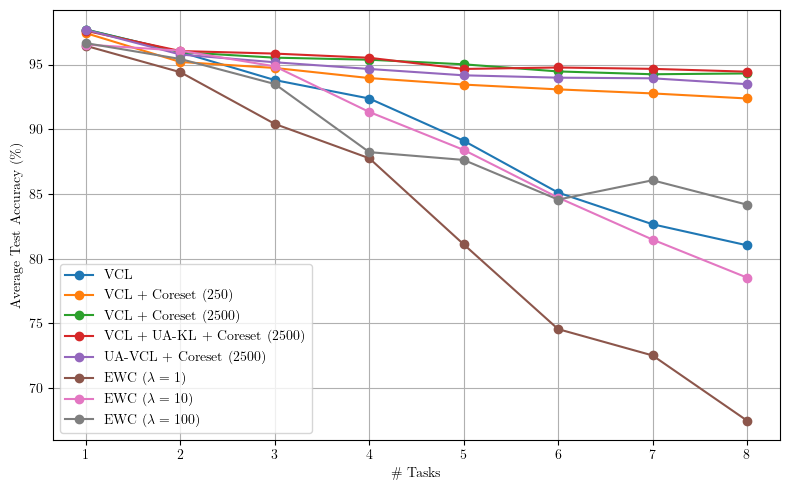

In [31]:
plt.figure(figsize=(8, 5))

# Iterate over each key in the results dictionary and plot the accuracies.
for key, value in classification_results.items():
    if any(substr in key for substr in ["CO", "alpha_0.5", "alpha_2", "coreset_5000"]):
      continue

    accuracies = value["accuracies"]
    tasks = np.arange(1, len(accuracies) + 1)
    label = generate_label(key)
    plt.plot(tasks, accuracies, marker='o', label=label)

plt.xlabel(r'\# Tasks')
plt.ylabel(r'Average Test Accuracy (\%)')
plt.xticks(np.arange(1, num_tasks + 1))
plt.legend(loc='lower left')
plt.grid(True)
plt.tight_layout()
plt.savefig('permuted_mnist_accuracy.pdf', format="pdf", bbox_inches='tight')
plt.show()

#### New Approaches Only

VCL_coreset_0_lambda_-1_alpha_1.0
VCL_coreset_250_lambda_-1_alpha_1.0
VCL_coreset_2500_lambda_-1_alpha_1.0
VCL-WKL_coreset_2500_lambda_-1_alpha_1.0
UA-VCL-WKL_coreset_2500_lambda_-1_alpha_1.0


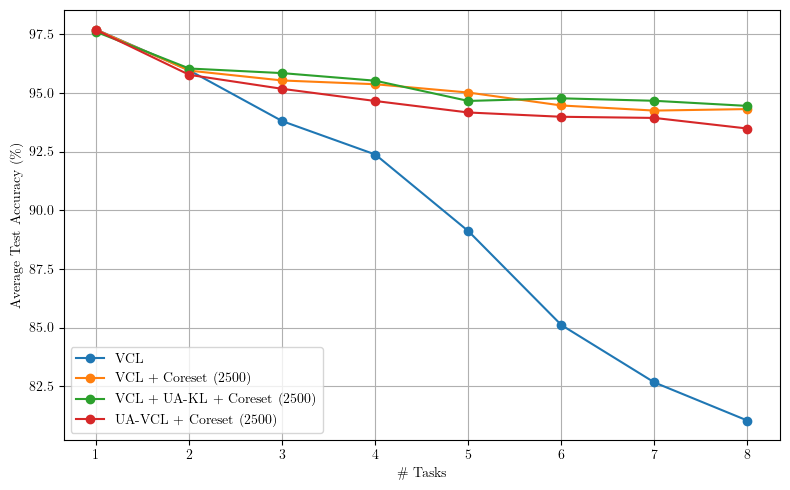

In [30]:
plt.figure(figsize=(8, 5))

# Iterate over each key in the results dictionary and plot the accuracies.
for key, value in classification_results.items():
    # For this plot, include novel methods and remove some of the original ones.
    if any(substr in key for substr in ["EWC", "CO", "alpha_0.5", "alpha_2", "coreset_5000"]):
      continue

    accuracies = value["accuracies"]
    tasks = np.arange(1, len(accuracies) + 1)
    label = generate_label(key)

    if "(250)" in label:
      continue

    plt.plot(tasks, accuracies, marker='o', label=label)

plt.xlabel(r'\# Tasks')
plt.ylabel(r'Average Test Accuracy (\%)')
plt.xticks(np.arange(1, num_tasks + 1))
plt.legend(loc='lower left')
plt.grid(True)
plt.tight_layout()
plt.savefig('permuted_mnist_accuracy_new.pdf', format="pdf", bbox_inches='tight')
plt.show()

### Visualization #2: Impact of Coreset Size

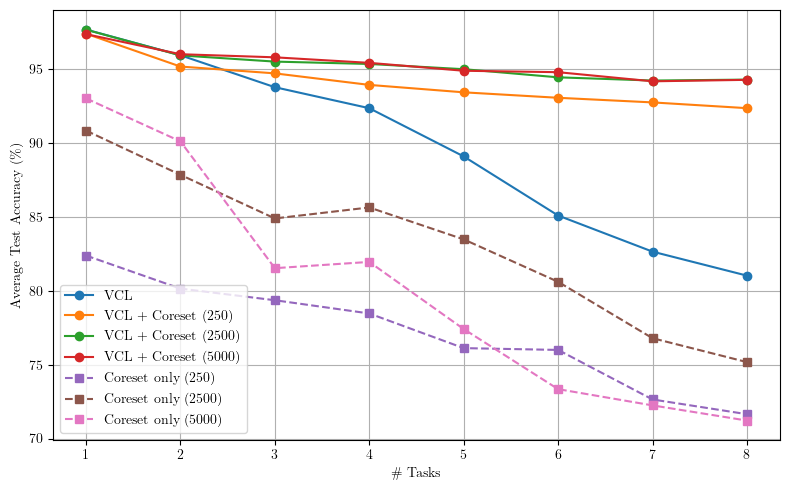

In [15]:
plt.figure(figsize=(8, 5))

# Iterate over each key in the results dictionary and plot the accuracies.
for key, value in classification_results.items():
    if "EWC" in key or "UA" in key or "WKL" in key:
      continue

    accuracies = value["accuracies"]
    tasks = np.arange(1, len(accuracies) + 1)
    label = generate_label(key)

    # Set different styles for curves pertaining to models only using coresets.
    if "CO" in key:
        marker = "s"
        linestyle = "--"
    else:
        marker = "o"
        linestyle = "-"

    plt.plot(tasks, accuracies, marker=marker, linestyle=linestyle, label=label)

plt.xlabel(r'\# Tasks')
plt.ylabel(r'Average Test Accuracy (\%)')
plt.xticks(np.arange(1, num_tasks + 1))
plt.legend(loc='lower left')
plt.grid(True)
plt.tight_layout()
plt.savefig('permuted_mnist_coreset_impact.pdf', format="pdf", bbox_inches='tight')
plt.show()

### Visualization #3: Average RMSE over Tasks

VCL_coreset_2500_lambda_-1_alpha_1.0
VCL_coreset_5000_lambda_-1_alpha_1.0
EWC_coreset_-1_lambda_1_alpha_-1
EWC_coreset_-1_lambda_10_alpha_-1
EWC_coreset_-1_lambda_100_alpha_-1


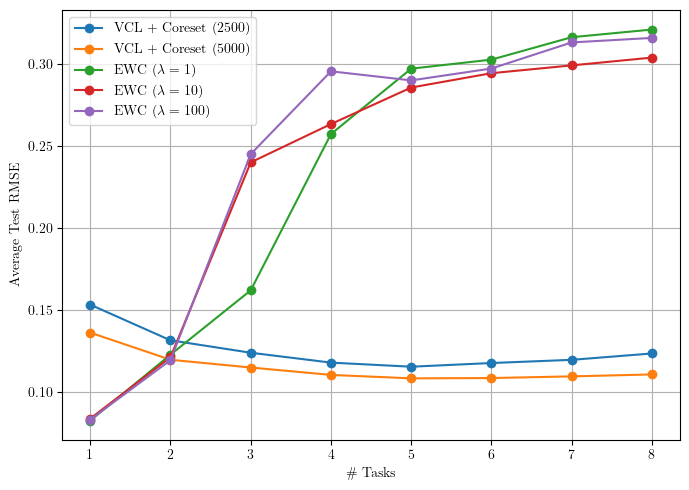

In [124]:
plt.figure(figsize=(7, 5))

# Iterate over each key in the regression_results dictionary and plot the RMSE values.
for key, value in regression_results.items():
    rmse_values = value["RMSE"]
    tasks = np.arange(1, len(rmse_values) + 1)
    label = generate_label(key)
    plt.plot(tasks, rmse_values, marker='o', label=label)

plt.xlabel(r'\# Tasks')
plt.ylabel(r'Average Test RMSE')
plt.xticks(np.arange(1, num_tasks + 1))
plt.legend(loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.savefig('permuted_mnist_rmse.pdf', format="pdf", bbox_inches='tight')
plt.show()

### Visualization #4: Forgetting Curves

In [14]:
key = "UA-VCL-WKL_coreset_2500_lambda_-1_alpha_1.0"
key_vcl = "VCL_coreset_2500_lambda_-1_alpha_1.0"

#### New Visualization

<ipython-input-17-397ce09c6c54>:61: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout(rect=[0, 0.03, 1, 0.95])


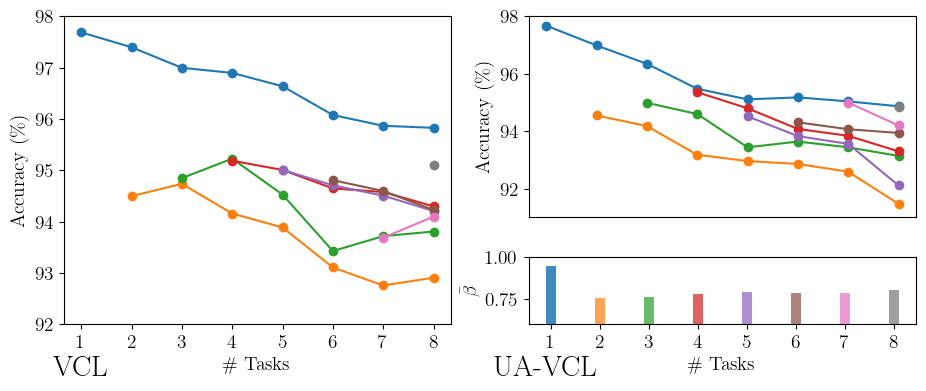

In [17]:
import matplotlib.gridspec as gridspec

fig = plt.figure(figsize=(11,4))
gs = gridspec.GridSpec(2, 2, width_ratios=[1,1], height_ratios=[3,1], hspace=0.3)

# Left subplot: Normal VCL accuracy curves (spanning both rows of left column).
ax_left = fig.add_subplot(gs[:, 0])
ax_left.set_xlabel(r'\# Tasks')
ax_left.set_ylabel('Accuracy (\%)')
for t in range(1, num_tasks+1):
    task_key = f"task_{t}"
    y_vals = classification_results[key_vcl][task_key]
    if not y_vals:
        continue
    x_vals = np.arange(t, t + len(y_vals))
    ax_left.plot(x_vals, y_vals, marker='o', label=f"Task {t}")
ax_left.tick_params(axis='y')
ax_left.set_ylim(92, 98)
ax_left.set_xticks(np.arange(1, num_tasks+1))
ax_left.text(1, 91.15, "VCL", ha='center', va='center', fontsize=21)

# Right top subplot: UA-VCL accuracy curves.
ax_right_acc = fig.add_subplot(gs[0, 1])
ax_right_acc.set_ylabel('Accuracy (\%)')
for t in range(1, num_tasks+1):
    task_key = f"task_{t}"
    y_vals = classification_results[key][task_key]
    if not y_vals:
        continue
    x_vals = np.arange(t, t + len(y_vals))
    ax_right_acc.plot(x_vals, y_vals, marker='o', label=f"Task {t}")
ax_right_acc.tick_params(axis='y')
ax_right_acc.set_ylim(91, 98)
ax_right_acc.set_xticks(np.arange(1, num_tasks+1))
ax_right_acc.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
ax_right_acc.text(1, 85.75, "UA-VCL", ha='center', va='center', fontsize=21)

# Right bottom subplot: β bars.
ax_right_beta = fig.add_subplot(gs[1, 1])
ax_right_beta.set_xlabel(r'\# Tasks')
ax_right_beta.set_ylabel(r'$\bar{\beta}$')
beta_vals = classification_results[key]['mean_beta']

# Every epoch the average beta value gets added, therefore
# take the mean of them and skip the ones pertaining to calculating
# the predictive distribution.
epochs = global_params['epochs']
group_means = [np.mean(beta_vals[i:i+epochs]) for i in range(0, len(beta_vals), epochs * 2)]
x_beta = np.arange(1, len(group_means) + 1)
for x, beta_val in zip(x_beta, group_means):
    normalized_alpha = beta_val * 0.8 + 0.1
    ax_right_beta.bar(x, beta_val, alpha=normalized_alpha, width=0.2)
ax_right_beta.tick_params(axis='y')
ax_right_beta.set_ylim(0.6, 1)
ax_right_beta.set_xticks(np.arange(1, num_tasks+1))

# Create a shared legend for the task curves.
# handles, labels = ax_left.get_legend_handles_labels()  # They should match those from ax_right_acc
# fig.legend(handles, labels, loc='upper center', ncol=len(labels), fontsize=12)

fig.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.savefig('forgetting_curves.pdf', format="pdf", bbox_inches='tight')
plt.show()

#### Old Visualization

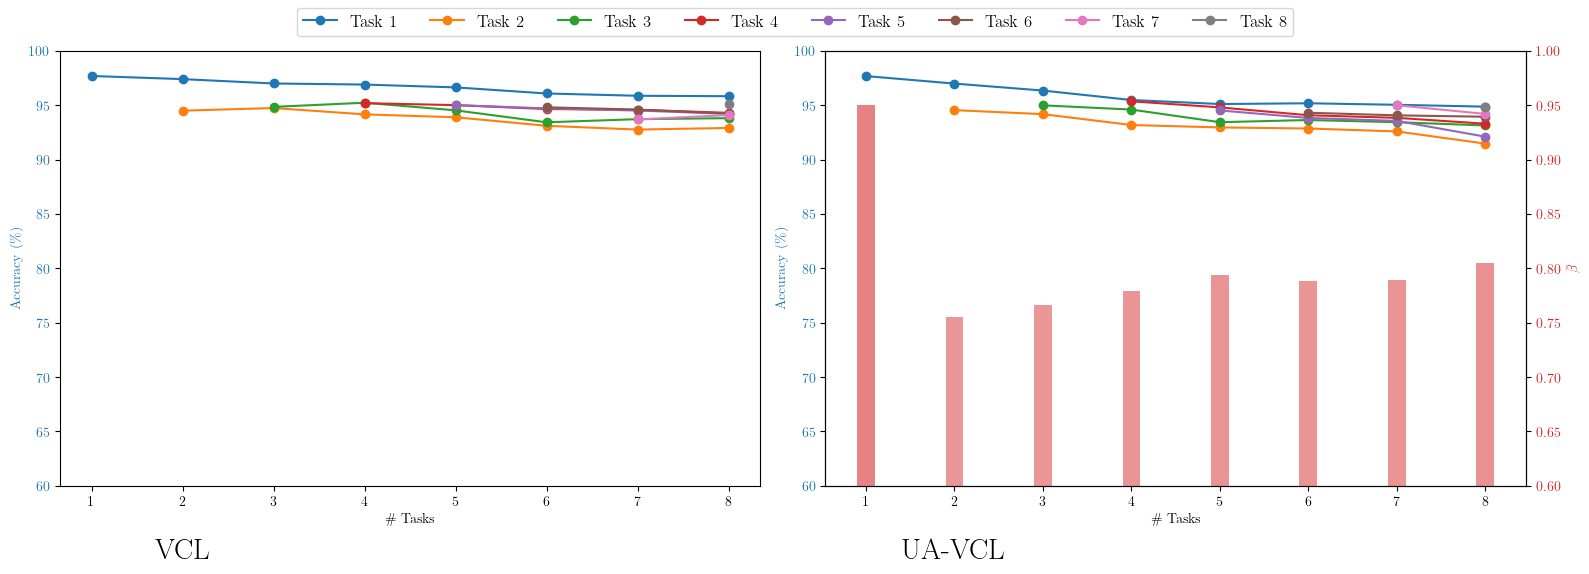

In [82]:
fig, (ax_left, ax_right) = plt.subplots(1, 2, figsize=(16, 6))

# Left subplot: Normal VCL accuracy curves.
ax_left.set_xlabel(r'\# Tasks')
ax_left.set_ylabel('Accuracy (\%)', color='tab:blue')
for t in range(1, num_tasks+1):
    task_key = f"task_{t}"
    y_vals = classification_results[key_vcl][task_key]
    if len(y_vals) == 0:
        continue
    x_vals = np.arange(t, t + len(y_vals))
    ax_left.plot(x_vals, y_vals, marker='o', label=f"Task {t}")
ax_left.tick_params(axis='y', labelcolor='tab:blue')
ax_left.set_ylim(60, 100)
ax_left.set_xticks(np.arange(1, num_tasks+1))
ax_left.text(2, 54, "VCL", ha='center', va='center', fontsize=21)

# Right subplot: UA-VCL with accuracy curves.
ax_right.set_xlabel(r'\# Tasks')
ax_right.set_ylabel('Accuracy (\%)', color='tab:blue')
for t in range(1, num_tasks+1):
    task_key = f"task_{t}"
    y_vals = classification_results[key][task_key]
    if len(y_vals) == 0:
        continue
    x_vals = np.arange(t, t + len(y_vals))
    ax_right.plot(x_vals, y_vals, marker='o', label=f"Task {t}")
ax_right.tick_params(axis='y', labelcolor='tab:blue')
ax_right.set_ylim(60, 100)
ax_right.set_xticks(np.arange(1, num_tasks+1))
ax_right.text(2, 54, "UA-VCL", ha='center', va='center', fontsize=21)

# Create a twin y-axis on the right subplot for beta bars.
ax_beta = ax_right.twinx()
ax_beta.set_ylabel(r'$\bar{\beta}$', color='tab:red')
x_beta = np.arange(1, len(group_means) + 1)
for x, beta_val in zip(x_beta, group_means):
    normalized_alpha = beta_val * 0.5 + 0.1
    ax_beta.bar(x, beta_val, color='tab:red', alpha=normalized_alpha, width=0.2)
ax_beta.tick_params(axis='y', labelcolor='tab:red')
ax_beta.set_ylim(0.6, 1)  # Changed lower limit from 0 to 0.6

# Create a shared legend from one of the axes.
handles, labels = ax_right.get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', ncol=len(labels), fontsize=12)

fig.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

### Visualization #5: $\alpha$-impact

In [10]:
# Define the alpha values to check.
selected_alphas = ['alpha_0.5', 'alpha_1', 'alpha_2']
tasks = [1, 3, 5, 8]

# Iterate over the keys in classification_results dict.
for key, result in classification_results.items():
    # Check for the novel model and if the key contains one of
    # the selected alpha strings.
    if key[:6] == "UA-VCL" and any(alpha_str in key for alpha_str in selected_alphas):
        print(f"Key: {key}")
        accuracies = result["accuracies"]
        for t in tasks:
            print(f"Task {t} average accuracy: {accuracies[t - 1]}")
        print("")

Key: UA-VCL-WKL_coreset_2500_lambda_-1_alpha_1.0
Task 1 average accuracy: 97.68
Task 3 average accuracy: 95.17333333333333
Task 5 average accuracy: 94.166
Task 8 average accuracy: 93.4825

Key: UA-VCL-WKL_coreset_2500_lambda_-1_alpha_0.5
Task 1 average accuracy: 97.8
Task 3 average accuracy: 94.89666666666666
Task 5 average accuracy: 93.98
Task 8 average accuracy: 93.595

Key: UA-VCL-WKL_coreset_2500_lambda_-1_alpha_2
Task 1 average accuracy: 97.64
Task 3 average accuracy: 94.93
Task 5 average accuracy: 94.416
Task 8 average accuracy: 93.21



### Visualization #6: Average Accuracy and RMSE over Tasks Combined

In [12]:
plt.rcParams.update({'font.size': 14})

VCL_coreset_0_lambda_-1_alpha_1.0
VCL_coreset_250_lambda_-1_alpha_1.0
VCL_coreset_2500_lambda_-1_alpha_1.0
VCL-WKL_coreset_2500_lambda_-1_alpha_1.0
UA-VCL-WKL_coreset_2500_lambda_-1_alpha_1.0
UA-VCL-WKL_coreset_2500_lambda_-1_alpha_1
EWC_coreset_-1_lambda_1_alpha_-1
EWC_coreset_-1_lambda_10_alpha_-1
EWC_coreset_-1_lambda_100_alpha_-1
VCL_coreset_2500_lambda_-1_alpha_1.0
VCL_coreset_5000_lambda_-1_alpha_1.0
EWC_coreset_-1_lambda_1_alpha_-1
EWC_coreset_-1_lambda_10_alpha_-1
EWC_coreset_-1_lambda_100_alpha_-1


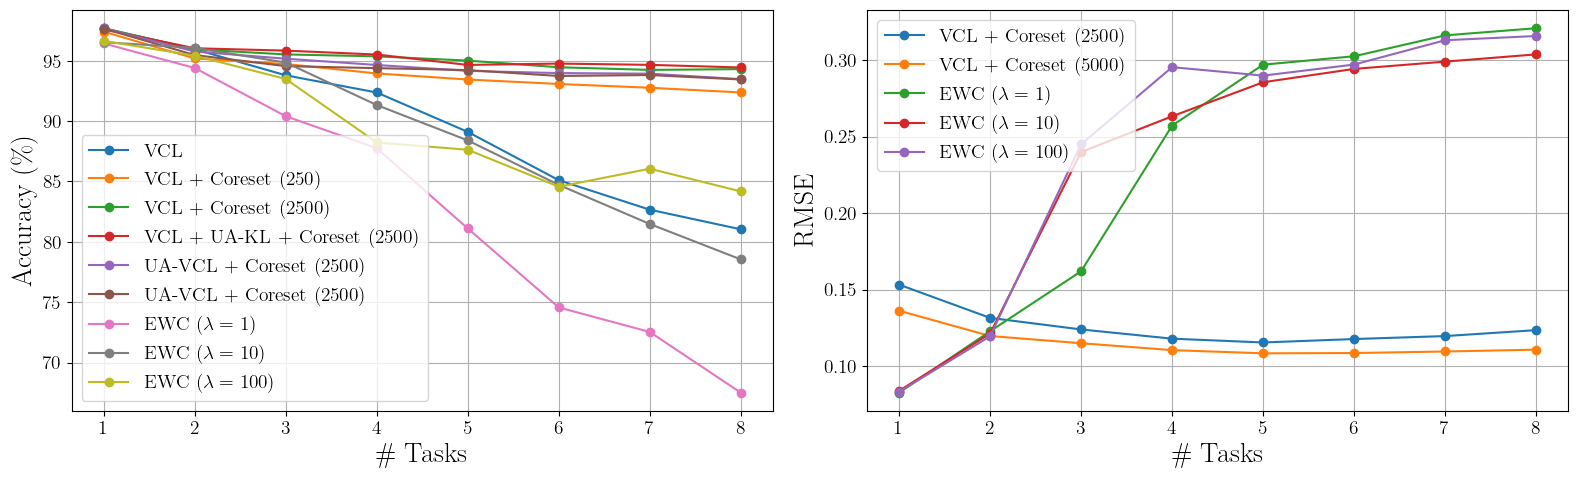

In [19]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 5))

# Plot accuracy curves on ax1
for key, value in classification_results.items():
    if any(substr in key for substr in ["CO", "alpha_0.5", "alpha_2", "coreset_5000"]):
        continue
    accuracies = value["accuracies"]
    tasks = np.arange(1, len(accuracies) + 1)
    label = generate_label(key)
    ax1.plot(tasks, accuracies, marker='o', label=label)
ax1.set_xlabel(r'\# Tasks', fontsize=20)
ax1.set_ylabel(r'Accuracy (\%)', fontsize=20)
ax1.set_xticks(np.arange(1, num_tasks + 1))
ax1.legend(loc='lower left')
ax1.grid(True)

# Plot RMSE curves on ax2
for key, value in regression_results.items():
    rmse_values = value["RMSE"]
    tasks = np.arange(1, len(rmse_values) + 1)
    label = generate_label(key)
    ax2.plot(tasks, rmse_values, marker='o', label=label)
ax2.set_xlabel(r'\# Tasks', fontsize=20)
ax2.set_ylabel(r'RMSE', fontsize=20)
ax2.set_xticks(np.arange(1, num_tasks + 1))
ax2.legend(loc='upper left')
ax2.grid(True)

fig.tight_layout()
plt.savefig('combined_plot.pdf', format="pdf", bbox_inches='tight')
plt.show()